# Genetic diversity and population structure

## Setup

In [1]:
### Load packages
library(MASS)
library(tidyverse)
library(emmeans)
library(gridExtra)
library(fs)
library(ggridges)
library(data.table)
library(RcppCNPy)
library(R.utils)
library(car)
library(ggrepel)
library(patchwork)
library(Cairo)
library(dplyr)
library(ggpubr)
library(IRdisplay)
library(lme4)
library(lmerTest)
library(MuMIn)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()


Attachement du package : ‘gridExtra’


L'objet suivant est masqué depuis ‘package:dplyr’:

    combine



Attachement du package : ‘data.table’


Les objets suivants sont masqués depuis ‘package:dplyr’:

    between, first, last


L'objet suivant est masqué depuis ‘package:purrr’:

    transpose


Le chargement a nécessité le package : R.oo

Le chargement a nécessité le package : R.methodsS3

R.methodsS3 v1.8.2 (2022-0

## Load summary dataset

In [2]:
# Load in summary datasets rather than re-summarizing from raw data
obs_div_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi.txt.bz2', delim = '\t'))  # Observed urban-rural thetas
obs_div_df<-subset(obs_div_df, city !='Bogota' & city !='Canberra' & city !='Hiroshima' & city!='Kyoto' & city!='Medellin' & city!='Melbourne' & city!='Paris')

obs_fst_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_fst.txt.bz2', delim = '\t'))  # Observed urban-rural fst
obs_fst_df<-subset(obs_fst_df, city !='Bogota' & city !='Canberra' & city !='Hiroshima' & city!='Kyoto' & city!='Medellin' & city!='Melbourne' & city!='Paris')


In [3]:
# Theme used for plotting
ng2 <- theme(panel.background = element_blank(),
             #aspect.ratio=0.5,
             panel.grid.major = element_blank(),
             panel.grid.minor = element_blank(),
             panel.border=element_blank(),
             axis.line.x = element_line(color="black",size=1),
             axis.line.y = element_line(color="black",size=1),
             axis.ticks=element_line(size = 1, color="black"),
             axis.ticks.length=unit(0.25, 'cm'),
             axis.text=element_text(color="black",size=15),
             axis.title=element_text(color="black",size=1),
             axis.title.y=element_text(vjust=2,size=17),
             #axis.title.x=element_text(vjust=0.1,size=17),
             axis.text.x=element_text(size=15,angle = 45,hjust = 1),
             axis.text.y=element_text(size=15),
             strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
             strip.background = element_rect(colour="black"),
             axis.title.x=element_blank(),
             legend.position = "top", 
             legend.direction="horizontal",
             legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
             legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"))

urban_col <- "#7b3294"
rural_col <- "#a6dba0"
cols <- c(urban_col, rural_col)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


## Editing files to have proper labels in figures

In [5]:
# generating file with details
## loading sample sheet
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
city_detail<-distinct(sample_sheet, city, .keep_all= TRUE)

## merging details per city to the diversity values
div_table<-merge(obs_div_df,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)
div_table$city<-sub("Cape_Town", "Cape Town", div_table$city)
div_table$city<-sub("Buenos_Aires", "Buenos Aires", div_table$city)
div_table$city<-sub("Mexico_City", "Mexico City", div_table$city)
div_table$city<-sub("Palmerston_North", "Palmerston N", div_table$city)
div_table$city<-sub("Punta_Arenas", "Punta Arenas", div_table$city)
div_table$continent<-sub("EU", "EUROPE", div_table$continent)
div_table$continent<-sub("ASI", "ASIA", div_table$continent)
div_table$continent<-sub("AFR", "AFR", div_table$continent)
div_table$continent<-sub("NAM", "NORTH AM.", div_table$continent)
div_table$continent<-sub("SAM", "SOUTH AM.", div_table$continent)
div_table$continent<-sub("OCE", "OCEANIA", div_table$continent)
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw',
                 'Tehran','Kunming','Sapporo','Cape Town',
                 'Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver',
                 'Buenos Aires','Loja','Punta Arenas','Quito',
                 'Armidale','Christchurch','Palmerston N') 

div_table$continent_order<-factor(div_table$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))


## Plot pi

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


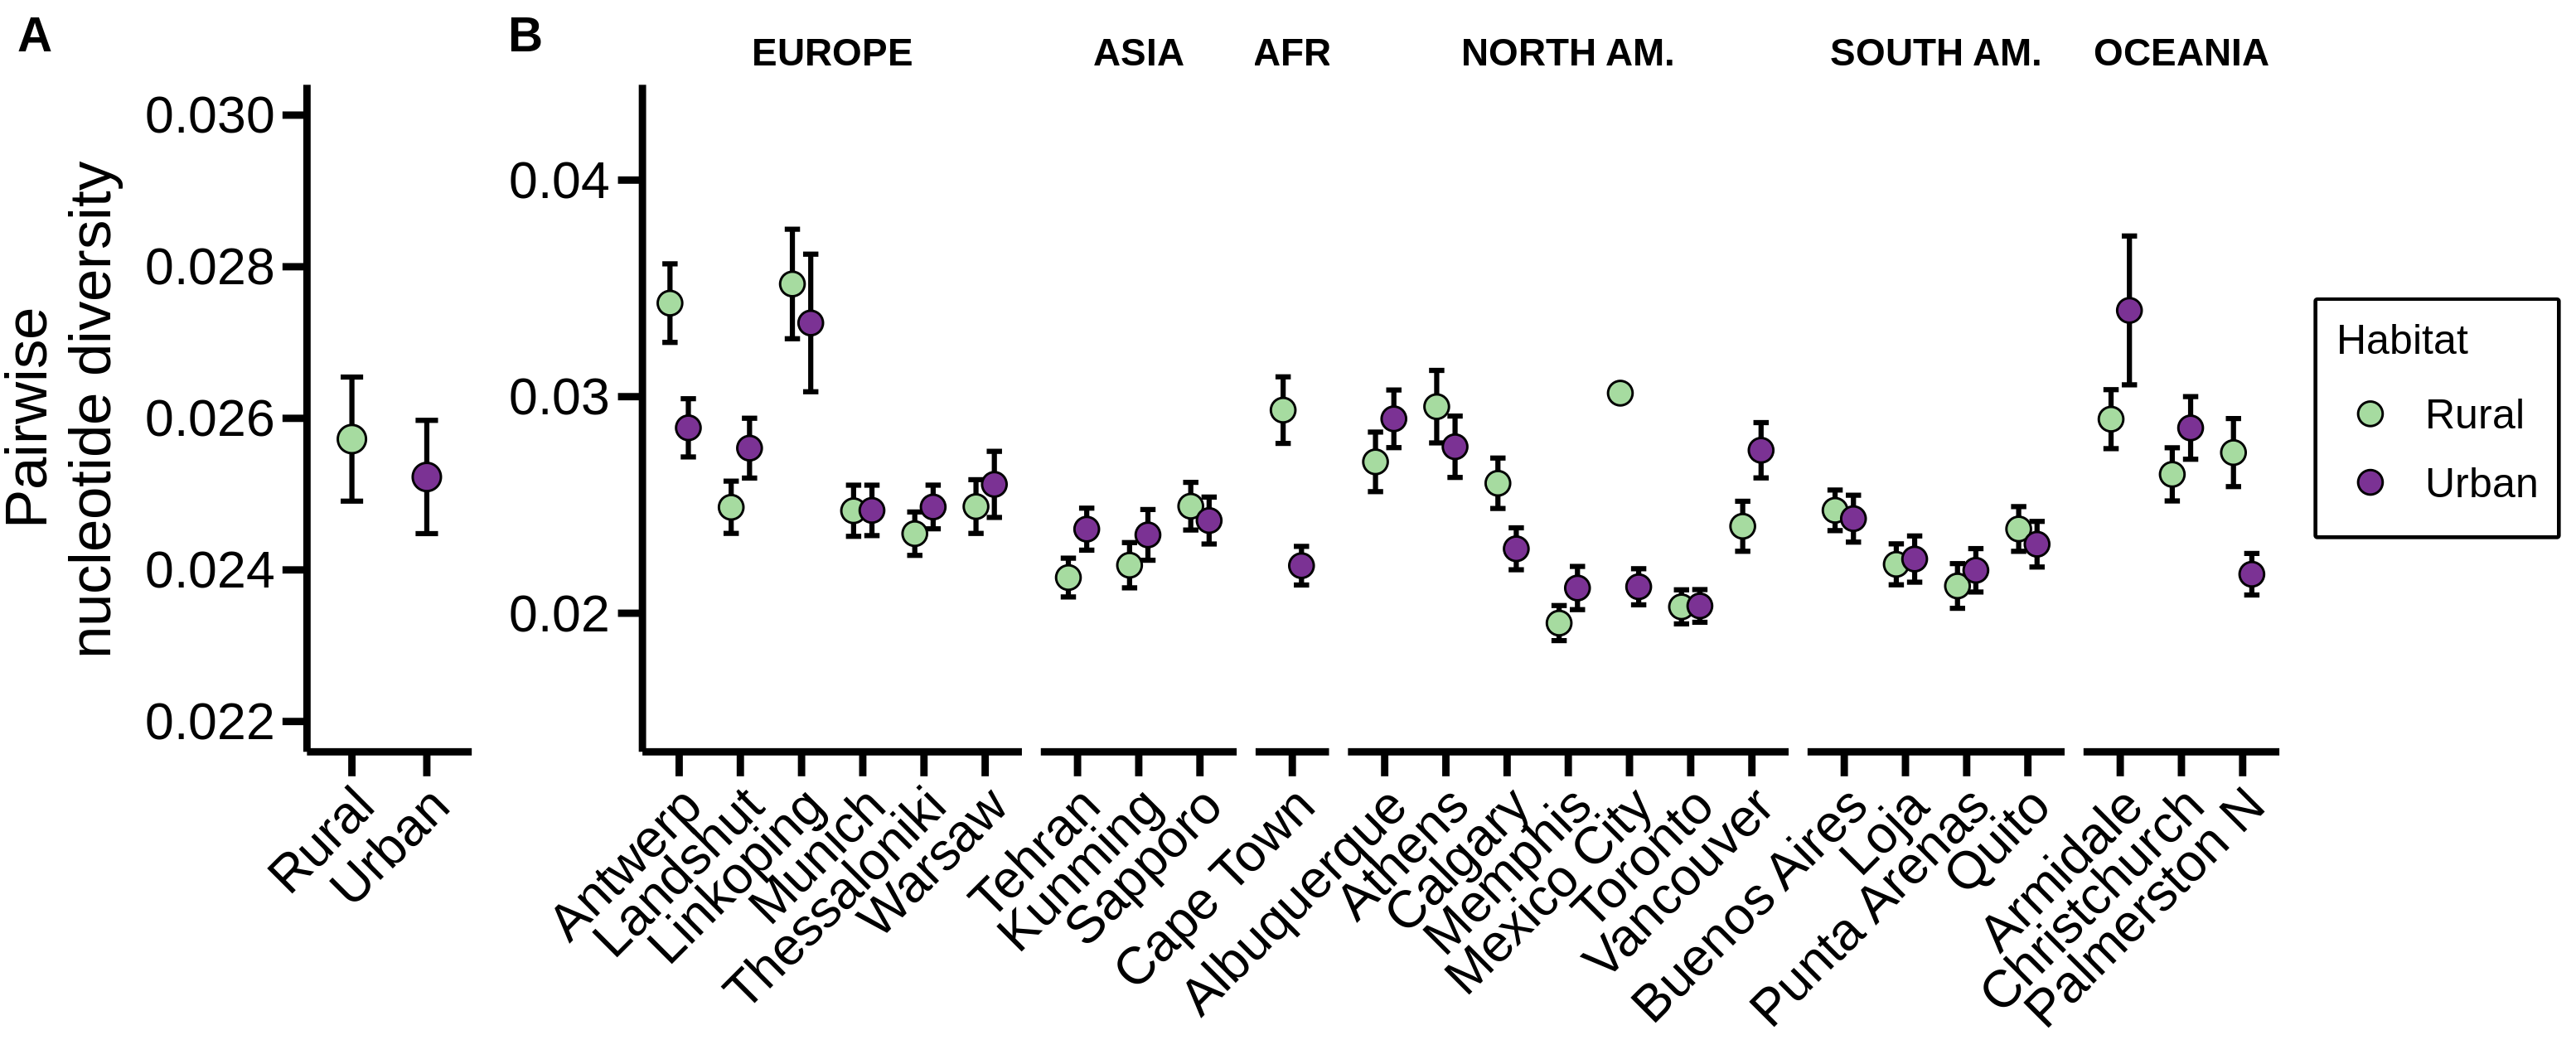

In [6]:
# Global pi
pi_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tp_mean),
            sd = sd(tp_mean),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.3, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(0.022,0.03)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab('Pairwise\n nucleotide diversity')  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# Pi per city per habitat
pi_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = tp_mean, fill = habitat)) +
  geom_errorbar(aes(ymax = tp_mean + tp_sd, ymin = tp_mean - tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.02,0.03,0.04),
                     limits = c(0.015,0.043))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

pi_combined<-ggarrange(pi_by_habitat,pi_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(pi_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="pi_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_mean_plot.png")


## Pi permutation

<font color='red'>TO BE COMPLETED</font>

## Plot Watterson's theta

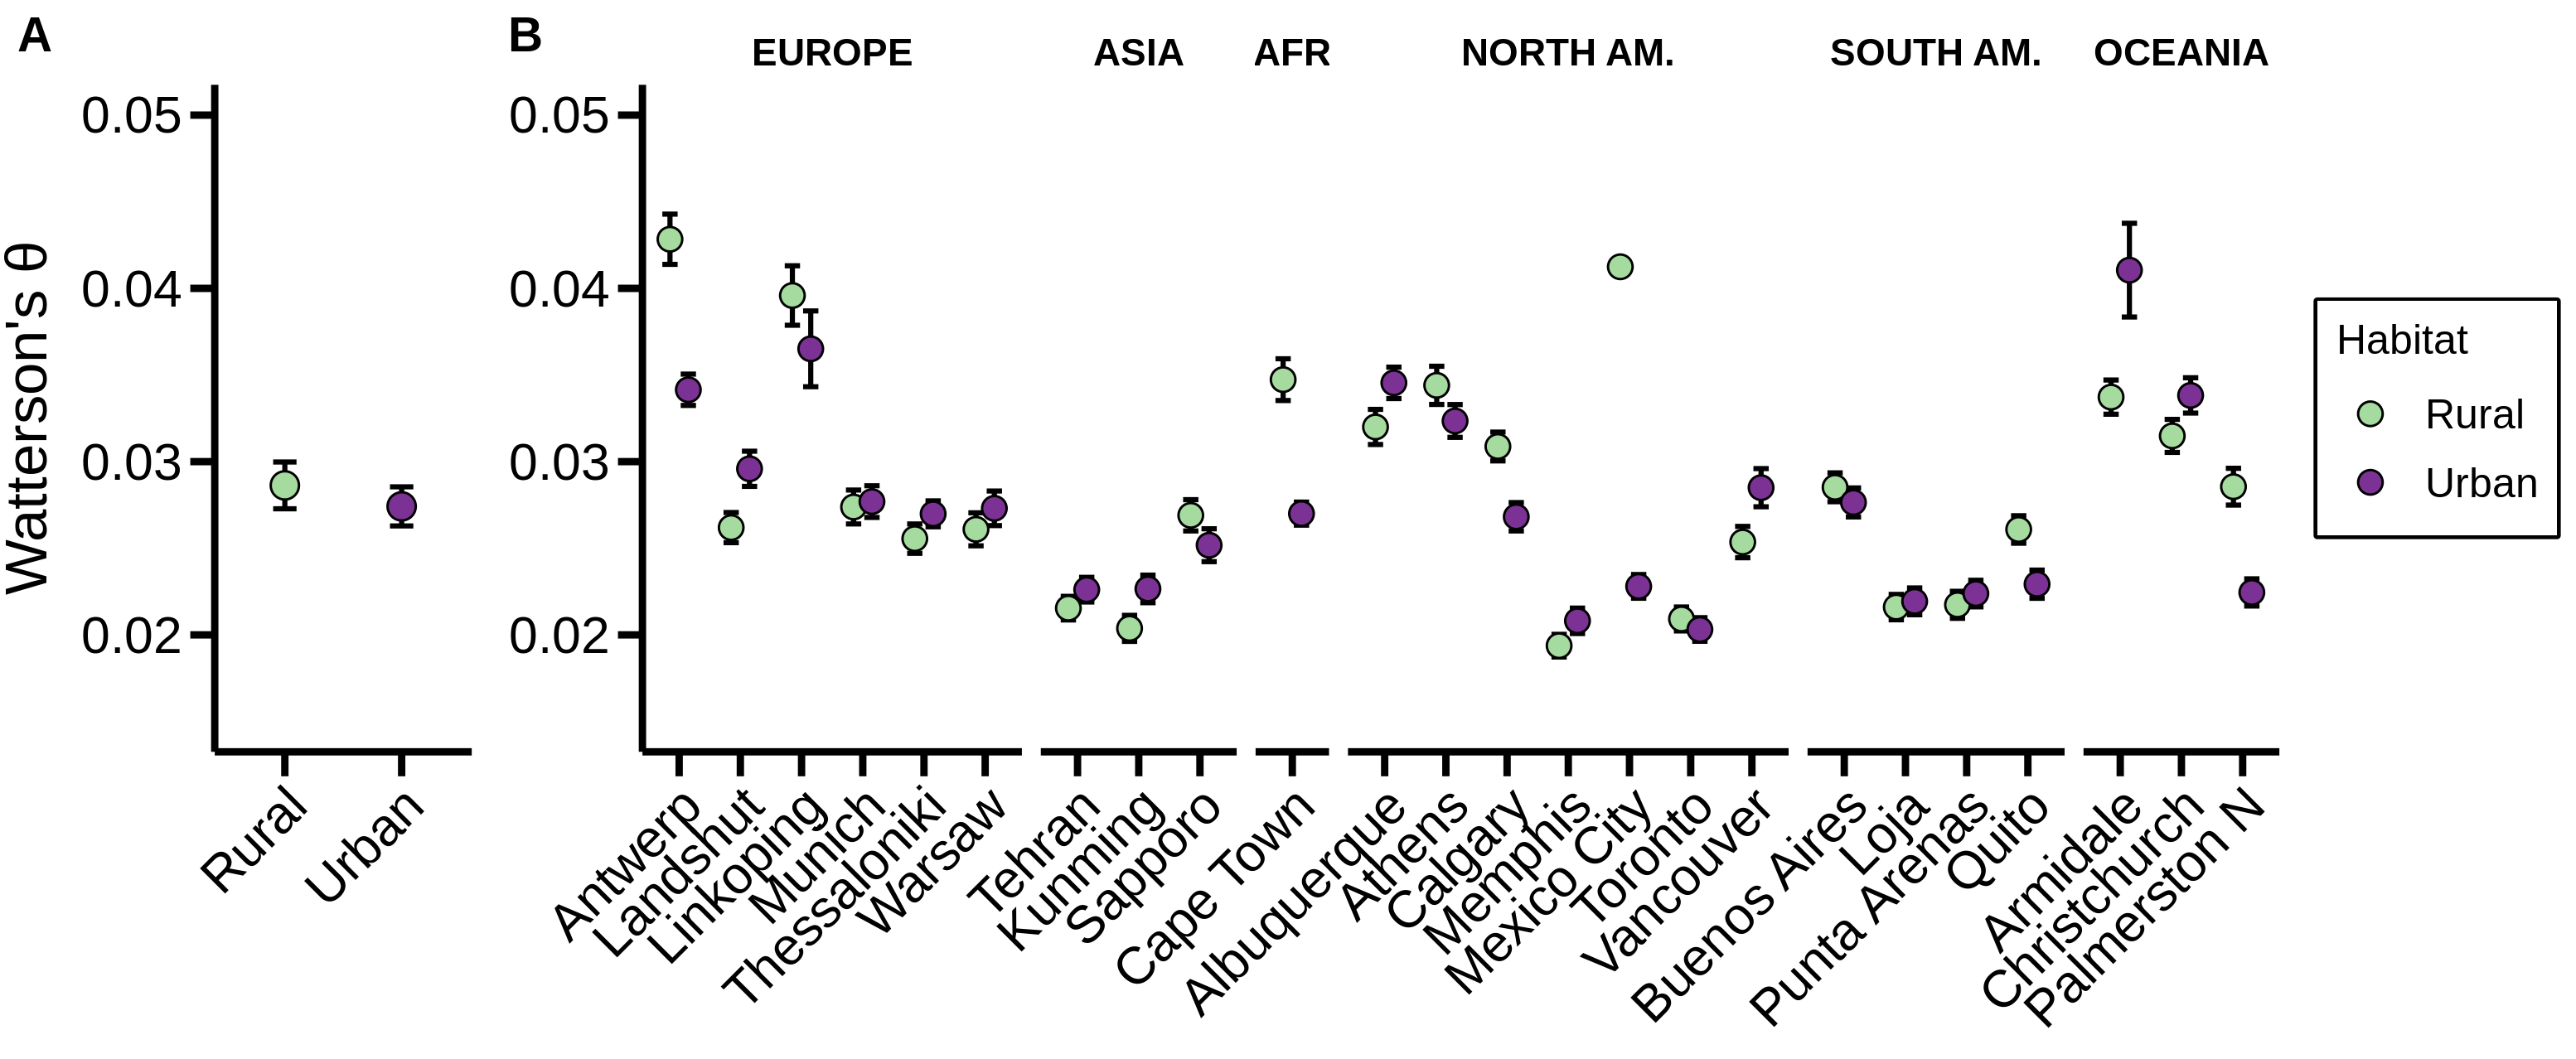

In [7]:
# Global theta
theta_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tw_mean),
            sd = sd(tw_mean),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(0.015,0.05)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab("Watterson's \u03B8")  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# theta per city per habitat
theta_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = tw_mean, fill = habitat)) +
  geom_errorbar(aes(ymax = tw_mean + tw_sd, ymin = tw_mean - tw_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(#breaks=c(0.02,0.03,0.04),
                     limits = c(0.015,0.05))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

theta_combined<-ggarrange(theta_by_habitat,theta_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))


ggsave(theta_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="theta_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/theta_mean_plot.png")



## Theta permutations

<font color='red'>TO BE COMPLETED</font>

## Plot Tajima's D

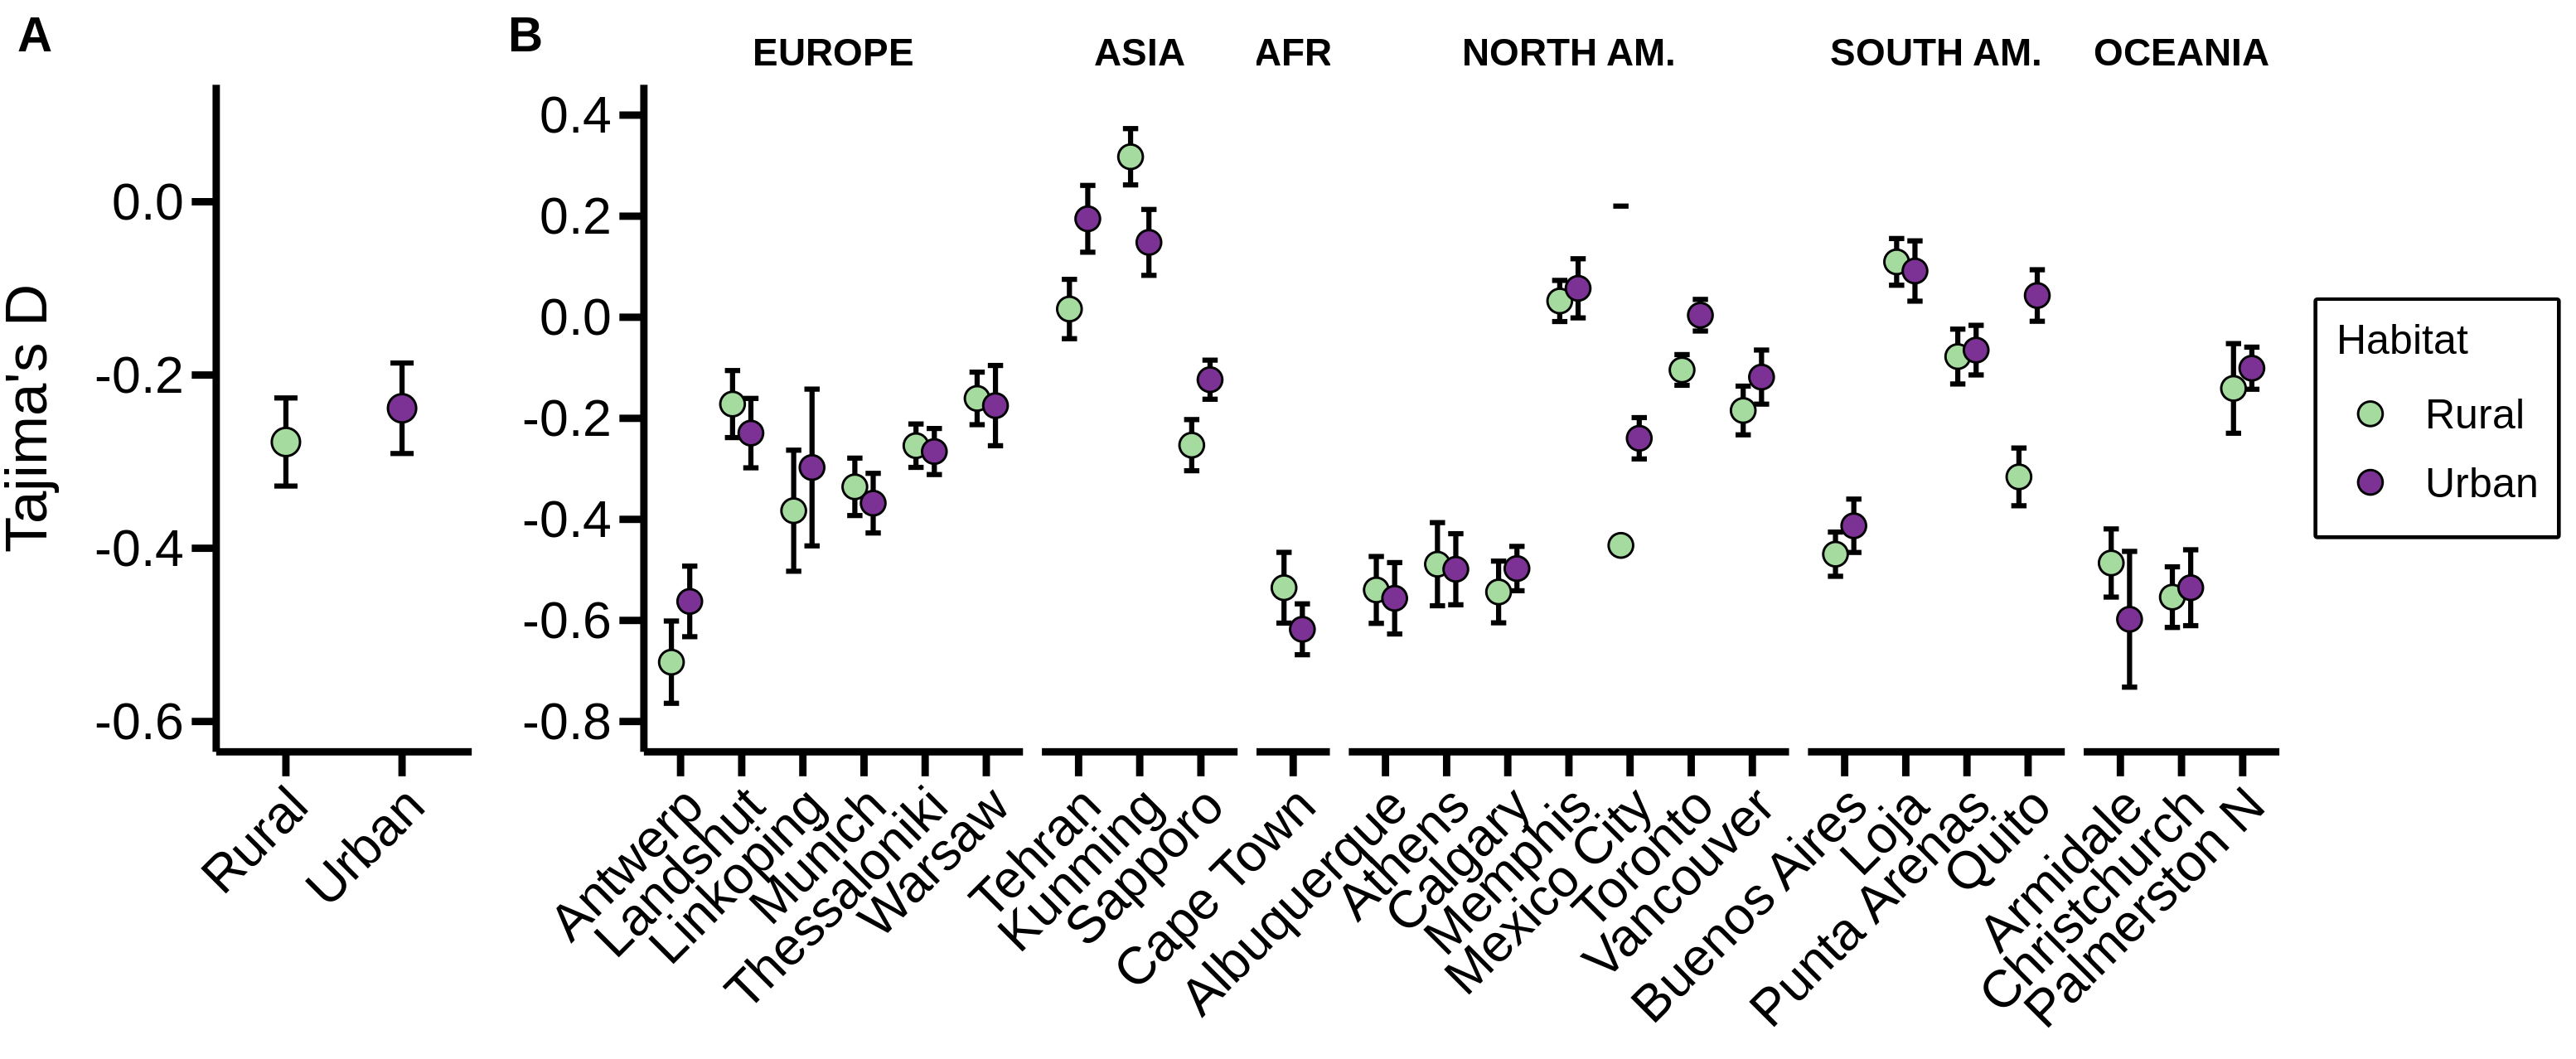

In [8]:
## Plot Tajima's D
# Global Dtaj
taj_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(taj),
            sd = sd(taj),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(-0.6,0.1)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab("Tajima's D")  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# theta per city per habitat
taj_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = taj, fill = habitat)) +
  geom_errorbar(aes(ymax = taj + taj_sd, ymin = taj - taj_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(-0.8,-0.6,-0.4,-0.2,0,0.2,0.4),
    limits = c(-0.8,0.4))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

taj_combined<-ggarrange(taj_by_habitat,taj_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(taj_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="tajima_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/tajima_mean_plot.png")


## Plot Fst

# Models

## Detailed table

In [12]:
# generating file with details
## loading sample sheet
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
city_detail<-distinct(sample_sheet, city, .keep_all= TRUE)

## merging details per city to the diversity values
div_table<-merge(obs_div_df,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)


## Pi

### Distribution

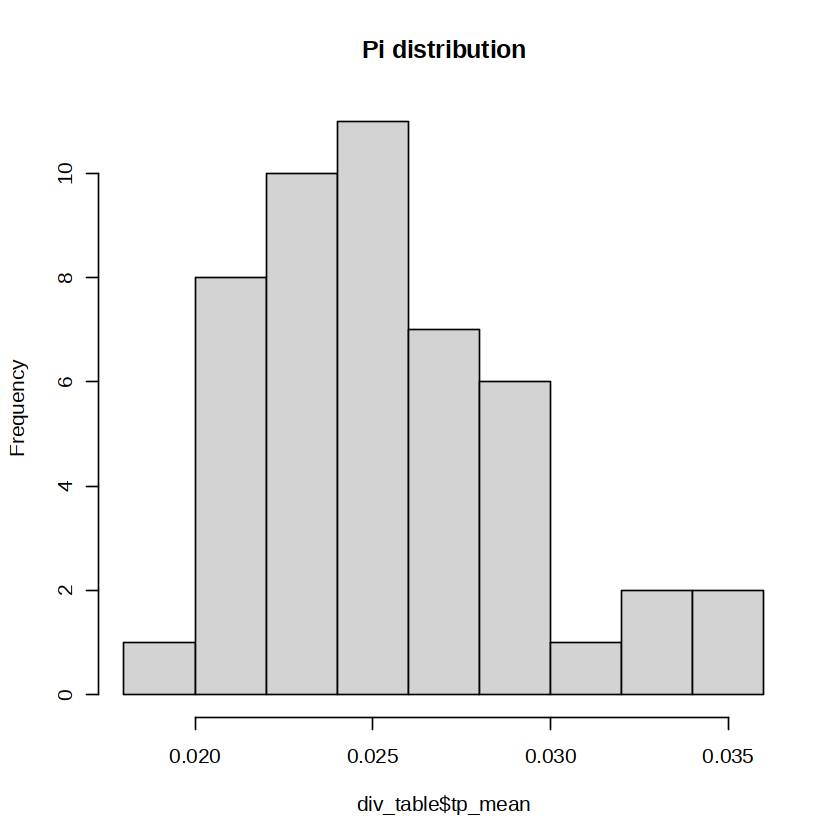

In [9]:
hist(div_table$tp_mean, main="Pi distribution") #normal distribution


### Model selection

In [12]:
mod_pi1<-lmer(tp_mean~habitat+continent+range+habitat*continent+habitat*range +(1|continent/city),data=div_table,na.action = "na.fail")
#mod<-dredge(mod_pi1, trace=T, rank="AICc", REML=T)
mod
# Anova on the best model conta
best_mod_pi<-lmer(tp_mean~habitat +(1|city),data=div_table,na.action = "na.fail")
anova(best_mod_pi)


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -2.3e-20”


,(Intercept),continent,habitat,range,continent:habitat,habitat:range,df,logLik,AICc,delta,weight
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
1,0.02543269,NA,NA,NA,NA,NA,4,199.1018,-389.2734,0.00000,9.973533e-01
5,0.02494712,NA,NA,+,NA,NA,5,194.1380,-376.8474,12.42606,1.997861e-03
3,0.02568265,NA,+,NA,NA,NA,5,193.0114,-374.5943,14.67915,6.476090e-04
7,0.02519708,NA,+,+,NA,NA,6,188.0476,-362.0464,27.22707,1.220577e-06
23,0.02529063,NA,+,+,NA,+,7,182.5894,-348.3788,40.89463,1.314298e-09
2,0.02578679,+,NA,NA,NA,NA,9,176.5717,-330.4065,58.86689,1.644620e-13
6,0.02578679,+,NA,+,NA,NA,10,171.9888,-318.0316,71.24183,3.379732e-16
4,0.02603675,+,+,NA,NA,NA,10,170.4813,-315.0166,74.25681,7.484946e-17
8,0.02603675,+,+,+,NA,NA,11,165.8984,-302.4634,86.81002,1.406992e-19


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
habitat,2.999049e-06,2.999049e-06,1,23,0.5045661,0.4846414


## Watterson's theta

### Distribution

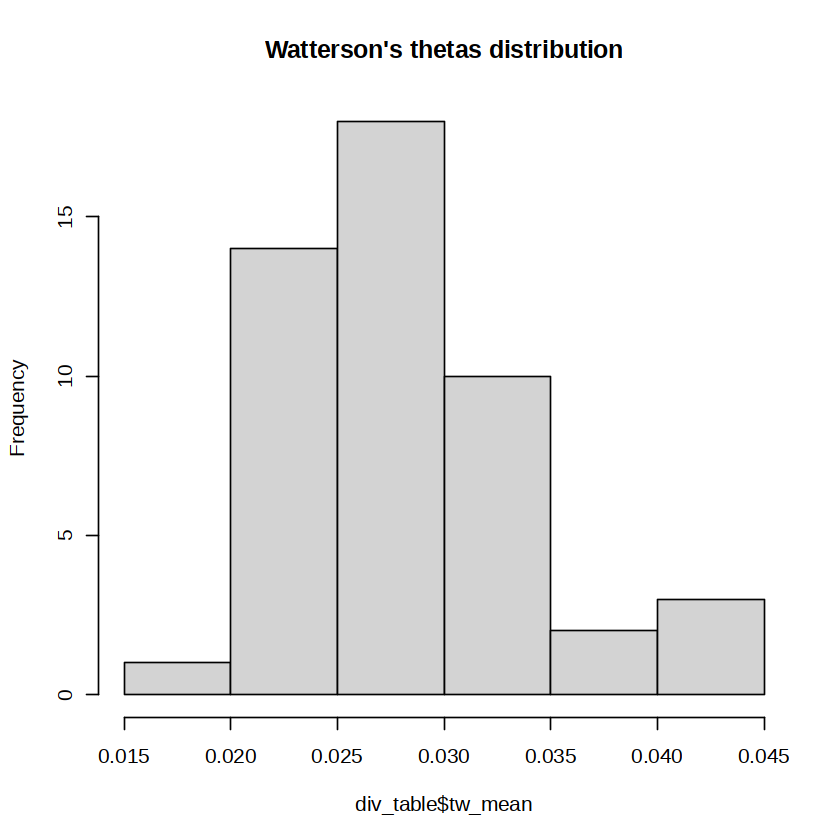

In [150]:
hist(div_table$tw_mean, main="Watterson's thetas distribution") #normal distribution


### Model selection

In [13]:
#finding the best model (with habitat variable) with AICc
mod_theta1<-lmer(tw_mean~habitat+continent+range+habitat*continent+habitat*range +(1|continent/city),data=div_table,na.action = "na.fail")
mod<-dredge(mod_theta1, trace=T, rank="AICc", REML=T)
mod
# Anova on the best model
best_mod_theta<-lmer(tw_mean~habitat +(1|city),data=div_table,na.action = "na.fail")
anova(best_mod_theta)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.9e-09”
Warning message in dredge(mod_theta1, trace = T, rank = "AICc", REML = T):
“comparing models fitted by REML”
Fixed term is "(Intercept)"



0 : lmer(formula = tw_mean ~ (1 | continent/city), data = div_table, 
    na.action = "na.fail")
1 : lmer(formula = tw_mean ~ continent + (1 | continent/city), data = div_table, 
    na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -5.3e-20”


2 : lmer(formula = tw_mean ~ habitat + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
3 : lmer(formula = tw_mean ~ continent + habitat + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -4.2e-20”


4 : lmer(formula = tw_mean ~ range + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
5 : lmer(formula = tw_mean ~ continent + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -1.3e-22”


6 : lmer(formula = tw_mean ~ habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")
7 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -2.2e-21”


11 : lmer(formula = tw_mean ~ continent + habitat + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -4.4e-21”


15 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -7.6e-21”


22 : lmer(formula = tw_mean ~ habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")
23 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -1.9e-09”


31 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat + habitat:range, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -8.9e-23”


,(Intercept),continent,habitat,range,continent:habitat,habitat:range,df,logLik,AICc,delta,weight
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
1,0.02794305,NA,NA,NA,NA,NA,4,177.7653,-346.6003,0.00000,9.960423e-01
5,0.02761162,NA,NA,+,NA,NA,5,173.0262,-334.6239,11.97643,2.498213e-03
3,0.02854869,NA,+,NA,NA,NA,5,172.4864,-333.5442,13.05615,1.456031e-03
7,0.02821726,NA,+,+,NA,NA,6,167.7473,-321.4459,25.15445,3.436042e-06
23,0.02833869,NA,+,+,NA,+,7,162.6783,-308.5566,38.04367,5.460099e-09
2,0.03086562,+,NA,NA,NA,NA,9,157.8122,-292.8875,53.71276,2.161225e-12
6,0.03086562,+,NA,+,NA,NA,10,153.7056,-281.4653,65.13497,7.151540e-15
4,0.03147126,+,+,NA,NA,NA,10,152.5333,-279.1206,67.47968,2.214379e-15
8,0.03147126,+,+,+,NA,NA,11,148.4267,-267.5201,79.08017,6.702517e-18


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
habitat,1.760631e-05,1.760631e-05,1,23,1.303166,0.2653821


## Tajima's D

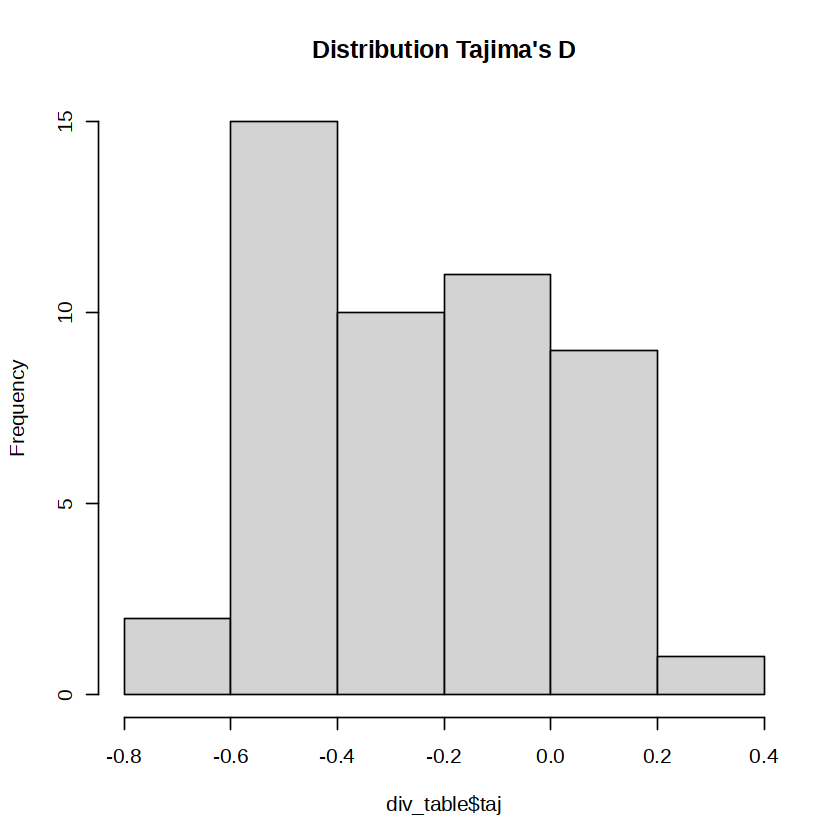

In [148]:
hist(div_table$taj, main="Tajima's D distribution")

### Model selection

In [14]:
#finding the best model (with habitat variable) with AICc
mod_taj1<-lmer(taj~habitat+continent+range+habitat*continent+habitat*range +(1|continent/city),data=div_table,na.action = "na.fail")
summary(mod_taj1)
mod<-dredge(mod_taj1, trace=T, rank="AICc", REML=T)
mod
# Anova on the best model
best_mod_taj<<-lmer(taj~habitat +(1|city),data=div_table,na.action = "na.fail")
anova(best_mod_taj)


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 5.4e-10”

Correlation matrix not shown by default, as p = 14 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: taj ~ habitat + continent + range + habitat * continent + habitat *  
    range + (1 | continent/city)
   Data: div_table

REML criterion at convergence: -15.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6261 -0.3867  0.0000  0.4318  1.6271 

Random effects:
 Groups         Name        Variance Std.Dev.
 city:continent (Intercept) 0.046741 0.21620 
 continent      (Intercept) 0.006684 0.08176 
 Residual                   0.006216 0.07884 
Number of obs: 48, groups:  city:continent, 24; continent, 6

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)                 -0.53527    0.24422 23.43096  -2.192   0.0386 *
habitatu                    -0.08228    0.11150 16.99998  -0.738   0.4706  
continentASIA                0.56751    0.30464 24.74830   1.863   0.0744 .
continentEUROPE              0.21993    0.39317 22.39611   0.

Warning message in dredge(mod_taj1, trace = T, rank = "AICc", REML = T):
“comparing models fitted by REML”
Fixed term is "(Intercept)"



0 : lmer(formula = taj ~ (1 | continent/city), data = div_table, 
    na.action = "na.fail")
1 : lmer(formula = taj ~ continent + (1 | continent/city), data = div_table, 
    na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -3.2e-10”


2 : lmer(formula = taj ~ habitat + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
3 : lmer(formula = taj ~ continent + habitat + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.9e-09”


4 : lmer(formula = taj ~ range + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
5 : lmer(formula = taj ~ continent + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -1.1e-09”


6 : lmer(formula = taj ~ habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")
7 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 8.3e-10”


11 : lmer(formula = taj ~ continent + habitat + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 4.2e-10”


15 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 7.2e-10”


22 : lmer(formula = taj ~ habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")
23 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.3e-09”


31 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat + habitat:range, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -3.6e-12”


,(Intercept),continent,habitat,range,continent:habitat,habitat:range,df,logLik,AICc,delta,weight
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
1,-0.2573370,NA,NA,NA,NA,NA,4,16.087463,-23.2446940,0.000000,8.376954e-01
5,-0.2709210,NA,NA,+,NA,NA,5,15.188169,-18.9477656,4.296928,9.772821e-02
3,-0.2768079,NA,+,NA,NA,NA,5,14.652855,-17.8771391,5.367555,5.721849e-02
7,-0.2903918,NA,+,+,NA,NA,6,13.753561,-13.4583405,9.786353,6.280677e-03
2,-0.5764095,+,NA,NA,NA,NA,9,15.948136,-9.1594301,14.085264,7.319980e-04
23,-0.2905091,NA,+,+,NA,+,7,11.688103,-6.5762051,16.668489,2.011730e-04
6,-0.5764095,+,NA,+,NA,NA,10,15.605015,-5.2640832,17.980611,1.043869e-04
4,-0.5958805,+,+,NA,NA,NA,10,14.513528,-3.0811102,20.163584,3.504447e-05
8,-0.5958805,+,+,+,NA,NA,11,14.170407,0.9925202,24.237214,4.571323e-06


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
habitat,0.01819778,0.01819778,1,23,2.935046,0.1001258


# Generate summary datasets

Note: This section only needs to be run to generate the summary datasets from the raw data output by the Snakemake pipeline. If the Snakemake pipeline hasn't been run, then the manuscript's results can be reproduced by running the analyses above using the summary datasets.

## Functions used to generate summary datasets

In [5]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(path)
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    
    full_path <- paste0(inpath, path)
    
    # Load dataframe
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site) %>% 

    # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat) %>% 
        summarise(tp_mean = mean(tp_scaled),
                  tw_mean = mean(tw_scaled),
                  tp_sd = sd(tp_scaled,na.rm=TRUE),
                  tw_sd = sd(tw_scaled, na.rm=TRUE),
                  taj= mean(Tajima),
                  taj_sd = sd(Tajima),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, tp_mean, tw_mean, tp_sd, tw_sd, taj, taj_sd, nSites)

    return(df)
    
}


# Function to load observed Fst df by city/habitat
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(path)
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city)
    
    return(df)
    
}

# Function to load permuted Fst df by city/habitat
load_perm_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city,
               seed = seed)
    
    return(df)
    
}

# Function to load admixture results from PCAngsd
load_admixture <- function(path){
    
    city <- basename(dirname(path))
    bam_list_path <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/by_city/withoutRelated/'
    samples <- suppressMessages(list.files(paste0(bam_list_path, city, '/'), 
                          pattern = '*lowCovRemoved*', 
                          full.names = TRUE) %>% 
        read_table(., col_names = FALSE)) %>% 
        mutate(sample = str_extract(X1, '(?<=\\/)\\w+_\\d+_\\d+(?=_4fold)')) %>% 
        pull(sample)
    
    df <- npyLoad(path) %>% 
        as_tibble() %>% 
        mutate(city = city,
               sample = samples)
    return(df)
}

## Write dataframes

### Urban-rural genetic diversity

In [6]:
# Concatenate urban and rural genetic diversity results (N = 2 habitats x 26 citis = 52) into single dataframe
inpath <- ' '
obs_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity)

# Write observed data to disc
write_delim(obs_div_df, '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)


city,habitat,tp_mean,tw_mean,tp_sd,tw_sd,taj,taj_sd,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Albuquerque,r,0.02698932,0.03200117,0.001375431,0.0010143774,-0.5396303,0.06615948,1014098
Albuquerque,u,0.02897677,0.03454662,0.001330479,0.0009070059,-0.5561956,0.07066635,805367
Antwerp,r,0.03431930,0.04283631,0.001813351,0.0014501993,-0.6826126,0.08142041,274252
Antwerp,u,0.02856077,0.03414765,0.001343769,0.0009041316,-0.5623712,0.06983064,925024
Armidale,r,0.02896160,0.03372373,0.001361144,0.0009864637,-0.4863528,0.06743949,966853
Armidale,u,0.03398263,0.04105213,0.003436243,0.0027046818,-0.5976881,0.13437001,162945


In [ ]:
# Permuted urban and rural pi
perm_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold_seed.*.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_permuted_pairwise_diversity) 

# Write permuted values to disc
write_delim(perm_div_df, '../analyses/tables/div_popStruct/permuted_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/permuted_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

### Urban-rural Fst

In [7]:
# Merge Fst dataframes. Using Hudson's Fst
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/hudson_fst/'
obs_fst_df <- list.files(inpath, pattern = '.*_4fold_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_obs_fst)

# Write observed Fst values to disc
write_delim(obs_fst_df, '../analyses/tables/div_popStruct/observed_fst.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_fst.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

In [ ]:
# Merge Fst dataframes. Only using Hudson's Fst
inpath <- '../../../results/angsd/summary_stats/hudson_fst/'
perm_fst_df <- list.files(inpath, pattern = '.*seed\\d+_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_perm_fst) 
    
# Write permuted Fst values to disc
write_delim(perm_fst_df, '../analyses/tables/div_popStruct/permuted_fst.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/permuted_fst.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

## Admixture

In [5]:
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/population_structure/pcangsd/by_city/pcangsd_withoutRelated/'
ss <- suppressMessages(
    read_delim(
        '../resources/glue_noLowCities_sampleSheet_noRelated.txt', 
                           delim = '\t')) %>% 
    dplyr::select(site, sample)

admix_df <- list.files(inpath, pattern = '*.Q.npy', recursive = TRUE, full.names = TRUE) %>% 
    map_dfr(., load_admixture) %>% 
    left_join(., ss, by = 'sample') %>% 
    pivot_longer(V1:V2, values_to = 'Probs')

# Write admixture dataframe to disc
write_delim(admix_df, '../analyses/tables/div_popStruct/admixture.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/admixture.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted
as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


ERROR: Error in if (length(x) > 1 || grepl("\n", x)) {: valeur manquante là où TRUE / FALSE est requis


In [6]:
# Write summary datasets to disc so analyses can be reproduced without running the pipeline
# This only needs to be run once and datasets with be git controlled and placed in data repositories
write_csv(obs_div_df, '../analyses/tables/observed_urban-rural_pi.csv')
#write_csv(perm_div_df, '../analyses/tables/permuted_urban-rural_pi.csv')
write_csv(obs_fst_df, '../analyses/tables/observed_fst.csv')
#write_csv(perm_fst_df, '../analyses/tables/permuted_fst.csv')